# Исследование тарифов оператора сотовой связи

В нашем распоряжении данные 500 пользователей сотового оператора «Мегалайн»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st
import numpy as np


import warnings # отключаем "бесполезные" предупреждения 
warnings.filterwarnings('ignore')

df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')


df_calls.info()#изучаем датасет со звонками
display(df_calls.head())

df_internet.info()#изучаем датасет с интернет-трафиком
display(df_internet.head())

df_messages.info()#изучаем датасет с смс
display(df_messages.head())

df_tariffs.info()#изучаем датасет с тарифами
display(df_tariffs.head())


df_users.info()#изучаем датасет с пользователями
display(df_users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


**Вывод: Есть немного пропусков, даты надо привести к формату, с которым можно работать, мегабайты надо перевести в гигабайты, т.к. цена в тарифах за гигабайт.** 

## Подготовка данных

In [2]:


df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')#приводим дату звонков в правильный формат

df_calls['month'] = df_calls['call_date'].dt.month #добавляем в таблицу месяц звонка

import math
df_calls['duration'] = df_calls['duration'].apply(math.ceil)#округляем длительность звонков до целого в большую сторону
display(df_calls.head())

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


In [3]:
#df_internet = df_internet.drop(df_internet.columns[[0]], axis=1) # удаляем ненужный столбец

df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')#приводим дату в правильный формат

df_internet['month'] = df_internet['session_date'].dt.month #добавляем в таблицу месяц, когда использовался интернет


display(df_internet.head())

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9


**Округлять интернет-трафик пока не будем, сделаем это после перевода в гигабайты**

In [4]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')#приводим дату в правильный формат

df_messages['month'] = df_messages['message_date'].dt.month #добавляем в таблицу месяц, когда отправлено SMS

display(df_messages.head())

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [5]:
#переводим в тарифах значения в гигабайты и переименовываем столбец
df_tariffs['mb_per_month_included'] = df_tariffs['mb_per_month_included'] / 1024
df_tariffs = df_tariffs.rename(columns = {'mb_per_month_included':'gb_per_month_included'})
df_tariffs['gb_per_month_included'] = df_tariffs['gb_per_month_included'].astype(int)
display(df_tariffs.head())

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


In [6]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')#приводим дату в правильный формат
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

#заполняем пропуски даты прекращения тарифа, предполагая что он действовал до конца года
df_users.loc[df_users['churn_date'].isna(), 'churn_date'] = df_users['churn_date'].max()


display(df_users.head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-30,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-30,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-30,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-30,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-30,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [7]:
df_users_small = df_users.drop(df_users.columns[[1, 2, 4, 5, 6]], axis=1) # удаляем несколько ненужных пока столбцов
display(df_users_small.head())

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


In [8]:
#создаем сводную таблицу количества SMS каждого пользователя по месяцам
df_messages_users_month = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
df_messages_users_month = df_messages_users_month.rename(columns = {'id':'messages'})

display(df_messages_users_month)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

In [9]:
#создаем сводную таблицу длительности звонков каждого пользователя по месяцам
df_calls_users_month = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
display(df_calls_users_month)

duration
user_id month          
1000    5           159
        6           172
        7           340
        8           408
        9           466
...                 ...
1498    10          247
1499    9            70
        10          449
        11          612
        12          492

[3174 rows x 1 columns]

In [10]:
#создаем сводную таблицу интернет-трафика каждого пользователя по месяцам
df_internet_users_month = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')

#переводим мегабайты в гигабайты т.к. цена в тарифах идет за гигабайт
df_internet_users_month['mb_used'] = df_internet_users_month['mb_used'] / 1024
df_internet_users_month = df_internet_users_month.rename(columns = {'mb_used':'gb_used'})

#округляем интернет-трафик до целого в большую сторону
df_internet_users_month['gb_used'] = df_internet_users_month['gb_used'].apply(math.ceil)

display(df_internet_users_month)

gb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
...                ...
1498    10          21
1499    9            2
        10          18
        11          18
        12          13

[3203 rows x 1 columns]

In [11]:
# объединяем сводные таблицы по звонкам и смс методом 'merge()'

stat_user_month = df_calls_users_month.merge(df_messages_users_month, on=['user_id', 'month'], how='outer')
stat_user_month.loc[stat_user_month['duration'].isna(), 'duration'] = 0.0
stat_user_month.loc[stat_user_month['messages'].isna(), 'messages'] = 0.0 # заполняем пропуски
display(stat_user_month)

duration  messages
user_id month                    
1000    5         159.0      22.0
        6         172.0      60.0
        7         340.0      75.0
        8         408.0      81.0
        9         466.0      57.0
...                 ...       ...
1489    8           0.0      17.0
        9           0.0      32.0
        10          0.0      21.0
        11          0.0      20.0
        12          0.0      35.0

[3213 rows x 2 columns]

In [12]:
# объединяем сводные таблицы по звонкам, смс и трафиком методом 'merge()'

stat_user_month = stat_user_month.merge(df_internet_users_month, on=['user_id', 'month'], how='outer')
stat_user_month.loc[stat_user_month['duration'].isna(), 'duration'] = 0.0
stat_user_month.loc[stat_user_month['messages'].isna(), 'messages'] = 0.0 # заполняем пропуски
stat_user_month.loc[stat_user_month['gb_used'].isna(), 'gb_used'] = 0.0
stat_user_month.info()
display(stat_user_month)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1476, 4)
Data columns (total 3 columns):
duration    3214 non-null float64
messages    3214 non-null float64
gb_used     3214 non-null float64
dtypes: float64(3)
memory usage: 248.8 KB


duration  messages  gb_used
user_id month                             
1000    5         159.0      22.0      3.0
        6         172.0      60.0     23.0
        7         340.0      75.0     14.0
        8         408.0      81.0     14.0
        9         466.0      57.0     15.0
...                 ...       ...      ...
1489    9           0.0      32.0     17.0
        10          0.0      21.0     20.0
        11          0.0      20.0     18.0
        12          0.0      35.0     17.0
1476    4           0.0       0.0      1.0

[3214 rows x 3 columns]

In [13]:
# добавляем в таблицу название тарифа и город
stat_user_month = stat_user_month.merge(df_users_small[['user_id', 'tariff', 'city']], on='user_id', how='left')
display(stat_user_month.head(20))

,user_id,duration,messages,gb_used,tariff,city
0,1000,159.0,22.0,3.0,ultra,Краснодар
1,1000,172.0,60.0,23.0,ultra,Краснодар
2,1000,340.0,75.0,14.0,ultra,Краснодар
3,1000,408.0,81.0,14.0,ultra,Краснодар
4,1000,466.0,57.0,15.0,ultra,Краснодар
5,1000,350.0,73.0,15.0,ultra,Краснодар
6,1000,338.0,58.0,15.0,ultra,Краснодар
7,1000,333.0,70.0,10.0,ultra,Краснодар
8,1001,430.0,0.0,18.0,smart,Москва
9,1001,414.0,0.0,14.0,smart,Москва


In [14]:
stat_user_month.shape

(3214, 6)

In [15]:
stat_user_month.user_id.nunique()

498

In [16]:
# пишу цикл для вычисления выручки с каждого пользователя помесячно

stat_user_month['proceeds'] = None # добавляем в таблицу столбец "Выручка"
i = 0
for i in range(len(stat_user_month['user_id'])):
    if stat_user_month['tariff'][i] == 'smart':   #для тарифа "Смарт"
        
        # условие-перерасхода нет
        if (stat_user_month['duration'][i] <= 500 and stat_user_month['messages'][i] <= 50 and stat_user_month['gb_used'][i] <= 15):
            stat_user_month['proceeds'][i] = 550
        
        # условие-перерасход минут
        elif (stat_user_month['duration'][i] > 500 and stat_user_month['messages'][i] <= 50 and stat_user_month['gb_used'][i] <= 15):
            stat_user_month['proceeds'][i] = 550 + (stat_user_month['duration'][i] - 500)*3
            
        # условие-перерасход смс    
        elif (stat_user_month['duration'][i] <= 500 and stat_user_month['messages'][i] > 50 and stat_user_month['gb_used'][i] <= 15):
            stat_user_month['proceeds'][i] = 550 + (stat_user_month['messages'][i] - 50)*3
            
        # условие-перерасход трафика    
        elif (stat_user_month['duration'][i] <= 500 and stat_user_month['messages'][i] <= 50 and stat_user_month['gb_used'][i] > 15):
            stat_user_month['proceeds'][i] = 550 + (stat_user_month['gb_used'][i] - 15)*200
            
        # условие-перерасход минут и смс    
        elif (stat_user_month['duration'][i] > 500 and stat_user_month['messages'][i] > 50 and stat_user_month['gb_used'][i] <= 15):
            stat_user_month['proceeds'][i] = 550 + (stat_user_month['duration'][i] - 500)*3 + (stat_user_month['messages'][i] - 50)*3
            
        # условие-перерасход минут и трафика    
        elif (stat_user_month['duration'][i] > 500 and stat_user_month['messages'][i] <= 50 and stat_user_month['gb_used'][i] > 15):
            stat_user_month['proceeds'][i] = 550 + (stat_user_month['duration'][i] - 500)*3 + (stat_user_month['gb_used'][i] - 15)*200
            
        # условие-перерасход смс и трафика    
        elif (stat_user_month['duration'][i] <= 500 and stat_user_month['messages'][i] > 50 and stat_user_month['gb_used'][i] > 15):
            stat_user_month['proceeds'][i] = 550 + (stat_user_month['messages'][i] - 50)*3 + (stat_user_month['gb_used'][i] - 15)*200
        
        # условие-перерасход минут, смс и трафика
        elif (stat_user_month['duration'][i] > 500 and stat_user_month['messages'][i] > 50 and stat_user_month['gb_used'][i] > 15):
            stat_user_month['proceeds'][i] = 550 + (stat_user_month['duration'][i] - 500)*3 + (stat_user_month['messages'][i] - 50)*3 + (stat_user_month['gb_used'][i] - 15)*200
    
    
    elif stat_user_month['tariff'][i] == 'ultra':   #для тарифа "Ультра"
        # условие-перерасхода нет
        if (stat_user_month['duration'][i] <= 3000 and stat_user_month['messages'][i] <= 1000 and stat_user_month['gb_used'][i] <= 30):
            stat_user_month['proceeds'][i] = 1950
        
        # условие-перерасход минут
        elif (stat_user_month['duration'][i] > 3000 and stat_user_month['messages'][i] <= 1000 and stat_user_month['gb_used'][i] <= 30):
            stat_user_month['proceeds'][i] = 1950 + (stat_user_month['duration'][i] - 3000)*1
            
        # условие-перерасход смс    
        elif (stat_user_month['duration'][i] <= 3000 and stat_user_month['messages'][i] > 1000 and stat_user_month['gb_used'][i] <= 30):
            stat_user_month['proceeds'][i] = 1950 + (stat_user_month['messages'][i] - 1000)*1
            
        # условие-перерасход трафика    
        elif (stat_user_month['duration'][i] <= 3000 and stat_user_month['messages'][i] <= 1000 and stat_user_month['gb_used'][i] > 30):
            stat_user_month['proceeds'][i] = 1950 + (stat_user_month['gb_used'][i] - 30)*150
            
        # условие-перерасход минут и смс    
        elif (stat_user_month['duration'][i] > 3000 and stat_user_month['messages'][i] > 1000 and stat_user_month['gb_used'][i] <= 30):
            stat_user_month['proceeds'][i] = 1950 + (stat_user_month['duration'][i] - 3000)*1 + (stat_user_month['messages'][i] - 1000)*1
            
        # условие-перерасход минут и трафика    
        elif (stat_user_month['duration'][i] > 3000 and stat_user_month['messages'][i] <= 1000 and stat_user_month['gb_used'][i] > 30):
            stat_user_month['proceeds'][i] = 1950 + (stat_user_month['duration'][i] - 3000)*1 + (stat_user_month['gb_used'][i] - 30)*150
            
        # условие-перерасход смс и трафика    
        elif (stat_user_month['duration'][i] <= 3000 and stat_user_month['messages'][i] > 1000 and stat_user_month['gb_used'][i] > 30):
            stat_user_month['proceeds'][i] = 1950 + (stat_user_month['messages'][i] - 1000)*1 + (stat_user_month['gb_used'][i] - 30)*150
        
        # условие-перерасход минут, смс и трафика
        elif (stat_user_month['duration'][i] > 3000 and stat_user_month['messages'][i] > 1000 and stat_user_month['gb_used'][i] > 30):
            stat_user_month['proceeds'][i] = 1950 + (stat_user_month['duration'][i] - 3000)*1 + (stat_user_month['messages'][i] - 1000)*1 + (stat_user_month['gb_used'][i] - 30)*150
    
    


stat_user_month['proceeds'] = stat_user_month['proceeds'].astype(float)
display(stat_user_month.head(10))        

,user_id,duration,messages,gb_used,tariff,city,proceeds
0,1000,159.0,22.0,3.0,ultra,Краснодар,1950.0
1,1000,172.0,60.0,23.0,ultra,Краснодар,1950.0
2,1000,340.0,75.0,14.0,ultra,Краснодар,1950.0
3,1000,408.0,81.0,14.0,ultra,Краснодар,1950.0
4,1000,466.0,57.0,15.0,ultra,Краснодар,1950.0
5,1000,350.0,73.0,15.0,ultra,Краснодар,1950.0
6,1000,338.0,58.0,15.0,ultra,Краснодар,1950.0
7,1000,333.0,70.0,10.0,ultra,Краснодар,1950.0
8,1001,430.0,0.0,18.0,smart,Москва,1150.0
9,1001,414.0,0.0,14.0,smart,Москва,550.0


In [17]:
stat_user_month['proceeds'].describe()

count    3214.000000
mean     1529.076229
std       798.251091
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: proceeds, dtype: float64

**Вывод: На шаге "подготовка данных" привели в порядок даты в наших датафреймах, добавили в таблицы столбец по месяцам, объединили сводные таблицы методом 'merge()'. Посчитали и добавили в таблицу выручку по месяцам по каждому пользователю.**

## Анализ данных

In [18]:
#разделим таблицы по тарифам методом "query"

stat_user_month_smart = stat_user_month.query('tariff in "smart"').reset_index(drop=True)
display(stat_user_month_smart.head())


stat_user_month_ultra = stat_user_month.query('tariff in "ultra"').reset_index(drop=True)
display(stat_user_month_ultra.head())


,user_id,duration,messages,gb_used,tariff,city,proceeds
0,1001,430.0,0.0,18.0,smart,Москва,1150.0
1,1001,414.0,0.0,14.0,smart,Москва,550.0
2,1002,117.0,4.0,11.0,smart,Стерлитамак,550.0
3,1002,214.0,11.0,18.0,smart,Стерлитамак,1150.0
4,1002,289.0,13.0,20.0,smart,Стерлитамак,1550.0


,user_id,duration,messages,gb_used,tariff,city,proceeds
0,1000,159.0,22.0,3.0,ultra,Краснодар,1950.0
1,1000,172.0,60.0,23.0,ultra,Краснодар,1950.0
2,1000,340.0,75.0,14.0,ultra,Краснодар,1950.0
3,1000,408.0,81.0,14.0,ultra,Краснодар,1950.0
4,1000,466.0,57.0,15.0,ultra,Краснодар,1950.0


In [19]:
# ПО ДАННЫМ ПОЛЬЗОВАТЕЛЕЙ С ТАРИФОМ "SMART"

#создаем сводную таблицу средней продолжительности звонков по каждому пользователю

#df_smart_duration_mean = stat_user_month_smart.pivot_table(index=['user_id','city'], values='duration', aggfunc='mean').round(0)

#создаем сводную таблицу среднего количества СМС по каждому пользователю

#df_smart_messages_mean = stat_user_month_smart.pivot_table(index=['user_id','city'], values='messages', aggfunc='mean').round(0)

#создаем сводную таблицу среднего трафика по каждому пользователю
#df_smart_gb_used_mean = stat_user_month_smart.pivot_table(index=['user_id','city'], values='gb_used', aggfunc='mean').round(0)

#создаем сводную таблицу средней выручки по каждому пользователю
#df_smart_proceeds_mean = stat_user_month_smart.pivot_table(index=['user_id','city'], values='proceeds', aggfunc='mean').round(0)


#объединяем полученые таблицы методом "merge"

#df_smart_mean = df_smart_duration_mean.merge(df_smart_messages_mean, on=['user_id','city'], how='outer')

#df_smart_mean = df_smart_mean.merge(df_smart_gb_used_mean, on=['user_id','city'], how='outer')

#df_smart_mean = df_smart_mean.merge(df_smart_proceeds_mean, on=['user_id','city'], how='outer')
#display(df_smart_mean.head())

In [20]:
# ПО ДАННЫМ ПОЛЬЗОВАТЕЛЕЙ С ТАРИФОМ "ULTRA"

#создаем сводную таблицу средней продолжительности звонков по каждому пользователю

#df_ultra_duration_mean = stat_user_month_ultra.pivot_table(index=['user_id','city'], values='duration', aggfunc='mean').round(0)

#создаем сводную таблицу среднего количества СМС по каждому пользователю

#df_ultra_messages_mean = stat_user_month_ultra.pivot_table(index=['user_id','city'], values='messages', aggfunc='mean').round(0)

#создаем сводную таблицу среднего трафика по каждому пользователю
#df_ultra_gb_used_mean = stat_user_month_ultra.pivot_table(index=['user_id','city'], values='gb_used', aggfunc='mean').round(0)

#создаем сводную таблицу средней выручки по каждому пользователю
#df_ultra_proceeds_mean = stat_user_month_ultra.pivot_table(index=['user_id','city'], values='proceeds', aggfunc='mean').round(0)


#объединяем полученые таблицы методом "merge"

#df_ultra_mean = df_ultra_duration_mean.merge(df_ultra_messages_mean, on=['user_id','city'], how='outer')

#df_ultra_mean = df_ultra_mean.merge(df_ultra_gb_used_mean, on=['user_id','city'], how='outer')

#df_ultra_mean = df_ultra_mean.merge(df_ultra_proceeds_mean, on=['user_id','city'], how='outer')
#display(df_ultra_mean.head())

Среднее количество минут в тарифе "Smart" : 418.0
ДИСПЕРСИЯ ПО ВЫБОРКЕ : 36219.0
СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ : 190.0


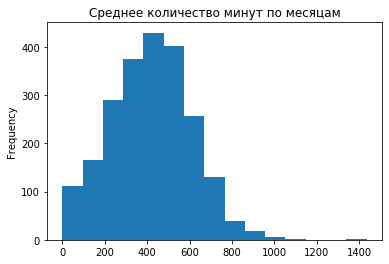

In [21]:

# МИНУТЫ В ТАРИФЕ "СМАРТ"

data_smart_duration = pd.Series(stat_user_month_smart['duration'].to_list())

mean_smart_duration = data_smart_duration.mean().round(0) # СРЕДНЕЕ
print('Среднее количество минут в тарифе "Smart" :',mean_smart_duration)
variance_estimate = np.var(data_smart_duration, ddof=1).round(0) #  ДИСПЕРСИЯ ПО ВЫБОРКЕ
print('ДИСПЕРСИЯ ПО ВЫБОРКЕ :',variance_estimate)
standard_deviation = np.std(data_smart_duration, ddof=1).round(0) # СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ
print('СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ :',standard_deviation)




data_smart_duration.plot(y='duration', kind='hist', title='Среднее количество минут по месяцам', bins=15)
plt.show()

**данные распределены нормально**

Среднее количество SMS в тарифе "Smart" : 33.0
ДИСПЕРСИЯ ПО ВЫБОРКЕ : 797.0
СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ : 28.0


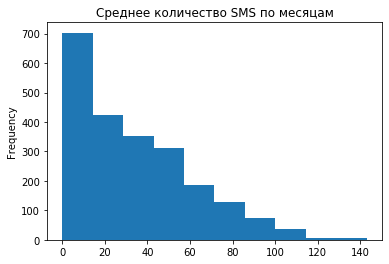

In [22]:
# СМС В ТАРИФЕ "СМАРТ"

data_smart_messages = pd.Series(stat_user_month_smart['messages'].to_list())

mean_smart_messages = data_smart_messages.mean().round(0) # СРЕДНЕЕ
print('Среднее количество SMS в тарифе "Smart" :',mean_smart_messages)
variance_estimate_s = np.var(data_smart_messages, ddof=1).round(0) #  ДИСПЕРСИЯ ПО ВЫБОРКЕ
print('ДИСПЕРСИЯ ПО ВЫБОРКЕ :',variance_estimate_s)
standard_deviation_s = np.std(data_smart_messages, ddof=1).round(0) # СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ
print('СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ :',standard_deviation_s)



data_smart_messages.plot(y='messages', kind='hist', title='Среднее количество SMS по месяцам', bins=10)
plt.show()

**Здесь наблюдается положительная скошенность, это говорит о том, что среднее больше, чем медиана**

Среднее количество гигабайт в тарифе "Smart" : 16.0
ДИСПЕРСИЯ ПО ВЫБОРКЕ : 33.0
СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ : 6.0


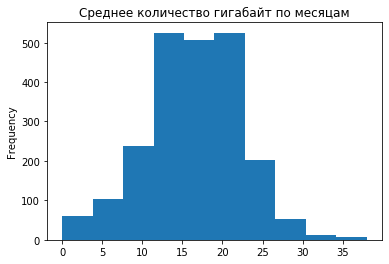

In [23]:
# ТРАФИК В ТАРИФЕ "СМАРТ"

data_smart_gb_used = pd.Series(stat_user_month_smart['gb_used'].to_list())

mean_smart_gb_used = data_smart_gb_used.mean().round(0) # СРЕДНЕЕ
print('Среднее количество гигабайт в тарифе "Smart" :',mean_smart_gb_used)
variance_estimate_t = np.var(data_smart_gb_used, ddof=1).round(0) #  ДИСПЕРСИЯ ПО ВЫБОРКЕ
print('ДИСПЕРСИЯ ПО ВЫБОРКЕ :',variance_estimate_t)
standard_deviation_t = np.std(data_smart_gb_used, ddof=1).round(0) # СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ
print('СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ :',standard_deviation_t)



data_smart_gb_used.plot(y='gb_used', kind='hist', title='Среднее количество гигабайт по месяцам', bins=10)
plt.show()

**данные распределены нормально**

Среднее количество минут в тарифе "Ultra" : 527.0
ДИСПЕРСИЯ ПО ВЫБОРКЕ : 100874.0
СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ : 318.0


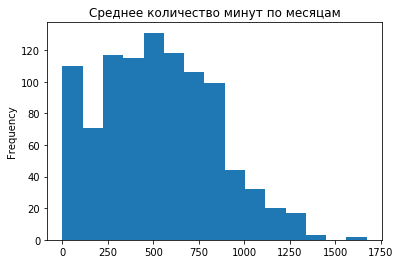

In [24]:
# МИНУТЫ В ТАРИФЕ "УЛЬТРА"

data_ultra_duration = pd.Series(stat_user_month_ultra['duration'].to_list())

mean_ultra_duration = data_ultra_duration.mean().round(0) # СРЕДНЕЕ
print('Среднее количество минут в тарифе "Ultra" :',mean_ultra_duration)
u_variance_estimate = np.var(data_ultra_duration, ddof=1).round(0) #  ДИСПЕРСИЯ ПО ВЫБОРКЕ
print('ДИСПЕРСИЯ ПО ВЫБОРКЕ :',u_variance_estimate)
u_standard_deviation = np.std(data_ultra_duration, ddof=1).round(0) # СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ
print('СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ :',u_standard_deviation)




data_ultra_duration.plot(y='duration', kind='hist', title='Среднее количество минут по месяцам', bins=15)
plt.show()

**Здесь наблюдается небольшая положительная скошенность, это говорит о том, что среднее немного больше, чем медиана**

Среднее количество SMS в тарифе "Ultra" : 49.0
ДИСПЕРСИЯ ПО ВЫБОРКЕ : 2285.0
СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ : 48.0


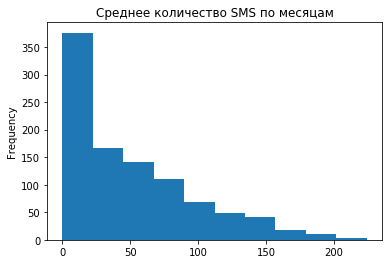

In [25]:
# СМС В ТАРИФЕ "УЛЬТРА"

data_ultra_messages = pd.Series(stat_user_month_ultra['messages'].to_list())

mean_ultra_messages = data_ultra_messages.mean().round(0) # СРЕДНЕЕ
print('Среднее количество SMS в тарифе "Ultra" :',mean_ultra_messages)
u_variance_estimate_s = np.var(data_ultra_messages, ddof=1).round(0) #  ДИСПЕРСИЯ ПО ВЫБОРКЕ
print('ДИСПЕРСИЯ ПО ВЫБОРКЕ :',u_variance_estimate_s)
u_standard_deviation_s = np.std(data_ultra_messages, ddof=1).round(0) # СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ
print('СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ :',u_standard_deviation_s)



data_ultra_messages.plot(y='messages', kind='hist', title='Среднее количество SMS по месяцам', bins=10)
plt.show()

**Здесь наблюдается положительная скошенность, это говорит о том, что среднее больше, чем медиана**

Среднее количество гигабайт в тарифе "Ultra" : 19.0
ДИСПЕРСИЯ ПО ВЫБОРКЕ : 97.0
СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ : 10.0


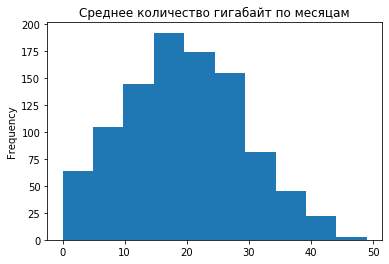

In [26]:
# ТРАФИК В ТАРИФЕ "УЛЬТРА"

data_ultra_gb_used = pd.Series(stat_user_month_ultra['gb_used'].to_list())

mean_ultra_gb_used = data_ultra_gb_used.mean().round(0) # СРЕДНЕЕ
print('Среднее количество гигабайт в тарифе "Ultra" :',mean_ultra_gb_used)
u_variance_estimate_t = np.var(data_ultra_gb_used, ddof=1).round(0) #  ДИСПЕРСИЯ ПО ВЫБОРКЕ
print('ДИСПЕРСИЯ ПО ВЫБОРКЕ :',u_variance_estimate_t)
u_standard_deviation_t = np.std(data_ultra_gb_used, ddof=1).round(0) # СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ
print('СТАНДАРТНОЕ ОТКЛОНЕНИЕ ПО ВЫБОРКЕ :',u_standard_deviation_t)



data_ultra_gb_used.plot(y='gb_used', kind='hist', title='Среднее количество гигабайт по месяцам', bins=10)
plt.show()

**данные распределены нормально**

## Проверка гипотез

***По условиям, поставленым в проекте, нужно проверить одну из гипотез: "средняя выручка пользователей тарифов "Ультра" и "Смарт" различается". Следовательно так и формулируем гипотезу Ho. Гипотезу H1 формулируем так: "средняя выручка пользователей тарифов "Ультра" и "Смарт" не различается" .***

In [27]:

# средняя выручка от пользователей с тарифом "Смарт"
data_smart_proceeds = pd.Series(stat_user_month_smart['proceeds'].to_list())

# средняя выручка от пользователей с тарифом "Ультра"
data_ultra_proceeds = pd.Series(stat_user_month_ultra['proceeds'].to_list())



alpha = 0.01#  критический уровень статистической значимости

results = st.ttest_ind(data_smart_proceeds, data_ultra_proceeds, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:# сравниваем получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0
Не получилось отвергнуть нулевую гипотезу


***Формулируем гипотезу Ho:"средняя выручка пользователей тарифа "Смарт" для Москвы и других городов отличается" . Гипотезу H1 формулируем так: "средняя выручка пользователей тарифа  "Смарт" для Москвы и других городов не отличается" .***

In [28]:
#формируем таблицы для тарифа "Смарт" отдельно для Москвы, отдельно для других городов
df_smart_mean_Moscow = stat_user_month_smart.query('city in "Москва"').reset_index(drop=True)
df_smart_mean_not_Moscow = stat_user_month_smart.query('city != "Москва"').reset_index(drop=True)

# средняя выручка от пользователей с тарифом "Смарт" для Москвы
data_smart_proceeds_Moscow = pd.Series(df_smart_mean_Moscow['proceeds'].to_list())

# средняя выручка от пользователей с тарифом "Смарт" для других городов
data_smart_proceeds_not_Moscow = pd.Series(df_smart_mean_not_Moscow['proceeds'].to_list())


alpha = 0.01#  критический уровень статистической значимости

results = st.ttest_ind(data_smart_proceeds_Moscow, data_smart_proceeds_not_Moscow, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:# сравниваем получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.15468343176376667
Не получилось отвергнуть нулевую гипотезу


***Формулируем гипотезу Ho:"средняя выручка пользователей тарифа "Ультра" для Москвы и других городов отличается" . Гипотезу H1 формулируем так: "средняя выручка пользователей тарифа  "Ультра" для Москвы и других городов не отличается" .***

In [29]:
#формируем таблицы для тарифа "Ультра" отдельно для Москвы, отдельно для других городов
df_ultra_mean_Moscow = stat_user_month_ultra.query('city in "Москва"').reset_index(drop=True)
df_ultra_mean_not_Moscow = stat_user_month_ultra.query('city != "Москва"').reset_index(drop=True)

# средняя выручка от пользователей с тарифом "Ультра" для Москвы
data_ultra_proceeds_Moscow = pd.Series(df_ultra_mean_Moscow['proceeds'].to_list())

# средняя выручка от пользователей с тарифом "Ультра" для других городов
data_ultra_proceeds_not_Moscow = pd.Series(df_ultra_mean_not_Moscow['proceeds'].to_list())


alpha = 0.01#  критический уровень статистической значимости

results = st.ttest_ind(data_ultra_proceeds_Moscow, data_ultra_proceeds_not_Moscow, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:# сравниваем получившееся p-значение с заданным уровнем статистической значимости:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8544997530689904
Не получилось отвергнуть нулевую гипотезу


**Использовал специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2,equal_var) .**

## Общий вывод

**Согласно ТЗ в данном проекте были подготовлены данные для дальнейшего исследования тарифов сотового оператора. По каждому пользователю в соответствии с используемым им тарифом были посчитаны помесячно количество минут, смс, интернет-трафика, а также выручка, которую получает оператор с пользователя.**

**Для тарифа "Смарт":**


**среднее количество минут проговариваемых клиентами: 418, дисперсия по выборке: 36219, стандартное отклонение по выборке: 190.**

**среднее количество СМС отправляемых клиентами: 32, дисперсия по выборке: 797, стандартное отклонение по выборке: 28.**

**среднее количество интернет-трафика используемого клиентами(в гигабайтах): 16, дисперсия по выборке: 33, стандартное отклонение по выборке: 6.**

**Для тарифа "Ультра":**

**среднее количество минут проговариваемых клиентами: 527, дисперсия по выборке: 100874, стандартное отклонение по выборке: 318.**

**среднее количество СМС отправляемых клиентами: 49, дисперсия по выборке: 2285, стандартное отклонение по выборке: 46.**

**среднее количество интернет-трафика используемого клиентами(в гигабайтах): 19, дисперсия по выборке: 97, стандартное отклонение по выборке: 10.**


**Мой вывод, что пользователи тарифа "Ультра", очень редко используют весь пакет услуг предоставляемый оператором в рамках тарифного плана, но стоит этот тариф почти в 4 раза дороже, чем "Смарт". В "Смарте" наоборот пользователям нехватает пакета, но даже с учетом перерасхода, услуги связи обходятся им дешевле чем "Ультра". Поэтому для пользователей несомненно лучше "Смарт", а для сотового оператора безусловно "Ультра".**

**Проверив данные в ТЗ гипотезы, вывод:**

**Выручка для тарифов "Ультра" и "Смарт" отличается.**

**Выручка для Москвы и других городов отличается.**